In [48]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
q = '''select advisory_id, package_id, ecosystem, type, severity, disclose_date, publish_date,
       fix_commit_date, release_date, version
        from
        (select advisory_id, min(commit_date) as fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where ecosystem = 'npm'
        and commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where ecosystem = 'npm'
        and type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id;'''
df = pd.DataFrame(sql.execute(q))
df['fix_to_release_delay'] = (df['release_date'].dt.date - df['fix_commit_date'].dt.date).dt.days
df= df[df['fix_to_release_delay'] >= 0]

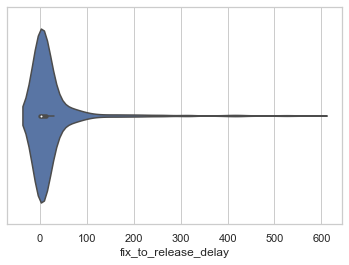

In [51]:
ax = sns.violinplot(x='fix_to_release_delay', data = df)

In [42]:
gb = df.groupby('ecosystem')
eco_dfs = [(x,gb.get_group(x)) for x in gb.groups]
len(eco_dfs)

1

In [44]:

for ecosystem,df in eco_dfs:
    print( ecosystem,df['advisory_id'].nunique(), df['package_id'].nunique(), df['type'].nunique(), df['fix_to_release_delay'].describe())
    wrong = df[df['fix_to_release_delay'] < 0]
    print(len(wrong))
wrong

npm 568 422 90 count     666.000000
mean       14.740240
std       110.779196
min     -1632.000000
25%         0.000000
50%         1.000000
75%        12.000000
max       574.000000
Name: fix_to_release_delay, dtype: float64
33


,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,fix_commit_date,release_date,version,fix_to_release_delay
47,npm:electron:20180123,124,npm,Directory Traversal,H,2018-01-23,2018-01-25,2018-03-15 05:23:49,2018-01-23 01:18:37,1.6.16,-51
48,npm:electron:20180123,124,npm,Directory Traversal,H,2018-01-23,2018-01-25,2018-03-15 05:23:49,2018-01-22 22:28:51,1.7.11,-52
49,npm:electron:20180123,124,npm,Directory Traversal,H,2018-01-23,2018-01-25,2018-03-15 05:23:49,2018-01-23 03:39:05,1.8.2-beta.4,-51
85,SNYK-JS-ELECTRON-565329,124,npm,Use After Free,H,2020-04-07,2020-04-13,2020-04-09 00:43:08,2020-03-23 15:50:54,9.0.0-beta.10,-17
88,SNYK-JS-ELECTRON-565362,124,npm,Improper Access Control,H,2020-03-18,2020-04-13,2020-04-09 00:02:51,2020-04-06 23:49:26,8.2.1,-3
90,SNYK-JS-ELECTRON-565364,124,npm,Use After Free,H,2020-03-18,2020-04-14,2020-04-08 00:51:49,2020-04-06 23:49:26,8.2.1,-2
93,SNYK-JS-ELECTRON-565366,124,npm,Use After Free,H,2020-04-14,2020-04-14,2020-04-08 00:41:36,2020-04-06 23:49:26,8.2.1,-2
96,SNYK-JS-ELECTRON-565368,124,npm,Use After Free,H,2020-03-18,2020-04-14,2020-04-08 00:36:37,2020-04-06 23:49:26,8.2.1,-2
122,SNYK-JS-NODESASS-540970,163,npm,Uncontrolled Recursion,H,2020-01-08,2020-01-08,2017-07-11 21:36:28,2017-01-27 02:27:08,4.4.0,-165
144,SNYK-JS-DEEPREF-1049536,302,npm,Prototype Pollution,H,2020-12-09,2020-12-09,2020-11-23 09:28:03,2016-06-05 16:34:01,1.2.1,-1632
